In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
from utilsCPD import *
import matplotlib.pyplot as plt
from SWCPD import BaseDetector as SWDCP


-2.536510378674192
-1.5517845015366234
3.8005273162210846
-2.2264303783045585
-2.0514006581530184
3.125518111635741


<Axes: >

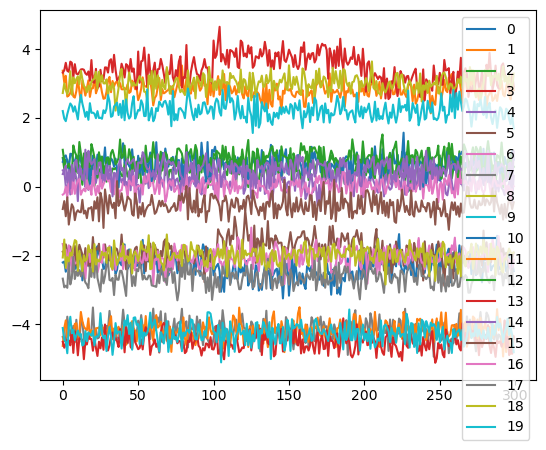

In [263]:
def make_dynamic_blobs(n_samples, base_center, n_clusters, varying_features, 
                       cluster_std=1.0, center_offset_range=(-5, 5), random_state=None):
    """
    Generate synthetic data with dynamic centers based on a base center and random offsets.
    
    Parameters:
        n_samples: int
            Total number of samples.
        base_center: array-like
            The center of the first cluster. Shape: (n_features,).
        n_clusters: int
            Number of clusters to generate.
        varying_features: list of int
            Indices of features that should vary across clusters.
        cluster_std: float
            Standard deviation of clusters.
        center_offset_range: tuple
            Range (min, max) for random uniform offsets added to the base center for varying features.
        random_state: int or None
            Random seed for reproducibility.
    
    Returns:
        X: ndarray of shape (n_samples, n_features)
            The generated samples.
        y: ndarray of shape (n_samples,)
            The integer labels for cluster membership.
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    n_features = len(base_center)
    samples_per_cluster = n_samples // n_clusters
    remainder = n_samples % n_clusters

    # Generate cluster centers
    centers = [np.array(base_center,dtype=float)]
    for _ in range(1, n_clusters):
        new_center = centers[0].copy()  # Start with the base center
        for feature in varying_features:
        
            new_center[feature] +=  np.random.uniform(*center_offset_range)
            print(new_center[feature])
            
        centers.append(new_center)
    centers = np.array(centers)
    
    # Generate points for each cluster
    X = []
    y = []
    for cluster_idx, center in enumerate(centers):
        cluster_size = samples_per_cluster + (1 if cluster_idx < remainder else 0)
        cluster_points = np.random.normal(
            loc=center,
            scale=cluster_std,
            size=(cluster_size, n_features)
        )
        X.append(cluster_points)
        y.extend([cluster_idx] * cluster_size)
    
    X = np.vstack(X)
    y = np.array(y)
    
    return X.astype(np.float32), y, centers

# Example Usage
base_center = list(np.random.uniform(-5,5,20))#,0,0,0,0]  # Base center for the first cluster
n_clusters = 3
n_samples = 300
varying_features = [0,5,3]#[0,5,3]#, 1,4,5,6]  # Only the first two features vary
X, y, centers = make_dynamic_blobs(
    n_samples=n_samples, 
    base_center=base_center, 
    n_clusters=n_clusters, 
    varying_features=varying_features, 
    cluster_std=0.25, 
    center_offset_range=(-0.5, 0.5), 
    random_state=2025
)

fig, ax = plt.subplots()
pd.DataFrame(X).plot(ax=ax,legend=True)


##for Plot swd_exp
#base_center = list(np.random.uniform(-5,5,10))#,0,0,0,0]  # Base center for the first cluster
# n_clusters = 3
# n_samples = 1500
# varying_features = [0,5,3]#, 1,4,5,6]  # Only the first two features vary
# X, y, centers = make_dynamic_blobs(
#     n_samples=n_samples, 
#     base_center=base_center, 
#     n_clusters=n_clusters, 
#     varying_features=varying_features, 
#     cluster_std=0.2, 
#     center_offset_range=(-2, 2), 
#     random_state=2025
#)

In [270]:
METRICS_SWD = {}
for id,i in enumerate(range(1)):
    print(id)
    METRICS_SWD[id]  = {}
    df, GroundTruth = X, np.where(np.diff(y)!=0)[0]+1
    print(GroundTruth)
    #100-100
    #50-50 for ExpPLot 
    detector = SWDCP(data=df,window_length=50,max_history=50,significance=0.01)
    print(detector.device)
    detector.process_dataloader(p=4,n_theta=5000,explanations=False,exp_param={'num_features_to_remove':3,'max_parameter':True,"q":0.95})
    METRICS_SWD[id]['F1'] =f_measure({'0':GroundTruth},detector.change_points['loc'],margin=20)
    METRICS_SWD[id]['Covering'] = covering({'0':GroundTruth},detector.change_points['loc'],n_obs=df.shape[0])
    print(METRICS_SWD[id])

0
[100 200]
cuda


 31%|███▏      | 79/251 [00:01<00:02, 69.72it/s]

Change detected at: 120 
Initiate new segment


 70%|██████▉   | 175/251 [00:02<00:01, 67.85it/s]

Change detected at: 215 
Initiate new segment


100%|██████████| 251/251 [00:03<00:00, 68.83it/s]

{'F1': (1.0, 1.0), 'Covering': 0.7929951690821256}


### Vary $\sigma$, $\delta$ 

In [150]:
base_center = list(np.random.uniform(-5,5,20))#,0,0,0,0]  # Base center for the first cluster

In [172]:
#base_center = list(np.random.uniform(-5,5,20))#,0,0,0,0]  # Base center for the first cluster

random_states = [2020,2021,2022,2023,2024]#,2021,2022,2023,2024,2025]
n_clusters = 3
n_samples = 1500
varying_features = [0,5,3]

SIGMA = [0.1,0.5,1]

METRICS = []
#METRICS[rs] = {}
RUN_STATS = {}
for sigma in SIGMA:
    RUN_STATS[str(sigma)] = {'F1 & AUC':[],'Covering':[]}
    for rs in random_states:
        print(rs,sigma)
        #RUN_STATS[sigma] = {}
        X, y, centers = make_dynamic_blobs(
            n_samples=n_samples, 
            base_center=base_center, 
            n_clusters=n_clusters, 
            varying_features=varying_features, 
            cluster_std=sigma, 
            center_offset_range=(-3, 3), 
            random_state=rs
        )
        df, GroundTruth = X, np.where(np.diff(y)!=0)[0]+1
        print(GroundTruth)
        detector = SWDCP(data=df,window_length=50,max_history=50,significance=0.05)
        print(detector.device)
        detector.process_dataloader(p=2,n_theta=5000,explanations=False)
        TMP = {}
        for margin in [5,10,20]:
            TMP[str(margin)] = f_measure({'0':GroundTruth},detector.change_points['loc'],margin=margin)
        RUN_STATS[str(sigma)]['F1 & AUC'].append(TMP)
        RUN_STATS[str(sigma)]['Covering'].append(covering({'0':GroundTruth},detector.change_points['loc'],n_obs=df.shape[0]))
        #print(RUN_STATS)
    #METRICS.append(RUN_STATS)
RUN_STATS


2020 0.1
0.7456624308174389
0.3007154706569266
3.4263948261640715
-3.540984256659699
-2.91812383779122
1.6696472664361277
[ 500 1000]
cuda


 32%|███▏      | 463/1451 [00:06<00:15, 65.09it/s]

Change detected at: 501 
Initiate new segment


 66%|██████▌   | 960/1451 [00:14<00:07, 63.54it/s]

Change detected at: 1001 
Initiate new segment


100%|██████████| 1451/1451 [00:22<00:00, 65.75it/s]


2021 0.1
-1.536128869507725
-0.5394200371060118
1.2016046167049748
-3.295960039224032
1.043823483774911
1.1368959288483462
[ 500 1000]
cuda


 32%|███▏      | 463/1451 [00:07<00:16, 60.05it/s]

Change detected at: 501 
Initiate new segment


 66%|██████▋   | 962/1451 [00:14<00:08, 58.84it/s]

Change detected at: 1001 
Initiate new segment


100%|██████████| 1451/1451 [00:22<00:00, 65.26it/s]


2022 0.1
-5.115846859505566
-1.9452893391550732
1.0482238159435928
-4.87215443328637
-0.8271906388084509
3.2898500856289643
[ 500 1000]
cuda


 32%|███▏      | 464/1451 [00:06<00:14, 69.00it/s]

Change detected at: 501 
Initiate new segment


 67%|██████▋   | 965/1451 [00:13<00:06, 75.90it/s]

Change detected at: 1001 
Initiate new segment


100%|██████████| 1451/1451 [00:19<00:00, 73.11it/s]


2023 0.1
-3.240068718400347
0.4028985064698838
3.8962352090374246
-4.412421981326406
-4.091588868817887
3.175295229983777
[ 500 1000]
cuda


 32%|███▏      | 462/1451 [00:06<00:13, 73.12it/s]

Change detected at: 501 
Initiate new segment


 66%|██████▋   | 963/1451 [00:12<00:06, 74.21it/s]

Change detected at: 1001 
Initiate new segment


100%|██████████| 1451/1451 [00:19<00:00, 74.75it/s]


2024 0.1
-1.6439114289797665
-0.7449837181775059
1.496833436565618
-4.909147159870965
-3.7095224899012686
1.0042989231921764
[ 500 1000]
cuda


 32%|███▏      | 462/1451 [00:06<00:13, 74.76it/s]

Change detected at: 501 
Initiate new segment


 67%|██████▋   | 966/1451 [00:13<00:06, 74.55it/s]

Change detected at: 1001 
Initiate new segment


100%|██████████| 1451/1451 [00:20<00:00, 70.05it/s]


2020 0.5
0.7456624308174389
0.3007154706569266
3.4263948261640715
-3.540984256659699
-2.91812383779122
1.6696472664361277
[ 500 1000]
cuda


 32%|███▏      | 469/1451 [00:06<00:13, 72.16it/s]

Change detected at: 504 
Initiate new segment


 66%|██████▋   | 962/1451 [00:13<00:06, 78.59it/s]

Change detected at: 1003 
Initiate new segment


100%|██████████| 1451/1451 [00:19<00:00, 73.81it/s]


2021 0.5
-1.536128869507725
-0.5394200371060118
1.2016046167049748
-3.295960039224032
1.043823483774911
1.1368959288483462
[ 500 1000]
cuda


 32%|███▏      | 471/1451 [00:06<00:12, 75.63it/s]

Change detected at: 509 
Initiate new segment


 67%|██████▋   | 967/1451 [00:13<00:06, 70.05it/s]

Change detected at: 1010 
Initiate new segment


100%|██████████| 1451/1451 [00:19<00:00, 73.38it/s]


2022 0.5
-5.115846859505566
-1.9452893391550732
1.0482238159435928
-4.87215443328637
-0.8271906388084509
3.2898500856289643
[ 500 1000]
cuda


 32%|███▏      | 468/1451 [00:06<00:12, 81.19it/s]

Change detected at: 508 
Initiate new segment


 67%|██████▋   | 973/1451 [00:12<00:06, 74.40it/s]

Change detected at: 1016 
Initiate new segment


100%|██████████| 1451/1451 [00:19<00:00, 76.09it/s]


2023 0.5
-3.240068718400347
0.4028985064698838
3.8962352090374246
-4.412421981326406
-4.091588868817887
3.175295229983777
[ 500 1000]
cuda


 32%|███▏      | 468/1451 [00:06<00:13, 74.74it/s]

Change detected at: 509 
Initiate new segment


 67%|██████▋   | 967/1451 [00:13<00:06, 75.30it/s]

Change detected at: 1005 
Initiate new segment


100%|██████████| 1451/1451 [00:19<00:00, 73.17it/s]


2024 0.5
-1.6439114289797665
-0.7449837181775059
1.496833436565618
-4.909147159870965
-3.7095224899012686
1.0042989231921764
[ 500 1000]
cuda


 33%|███▎      | 476/1451 [00:06<00:12, 76.38it/s]

Change detected at: 512 
Initiate new segment


 67%|██████▋   | 971/1451 [00:12<00:06, 72.99it/s]

Change detected at: 1005 
Initiate new segment


100%|██████████| 1451/1451 [00:19<00:00, 74.92it/s]


2020 1
0.7456624308174389
0.3007154706569266
3.4263948261640715
-3.540984256659699
-2.91812383779122
1.6696472664361277
[ 500 1000]
cuda


 32%|███▏      | 469/1451 [00:06<00:15, 64.51it/s]

Change detected at: 511 
Initiate new segment
Change detected at: 513 
Initiate new segment


 67%|██████▋   | 972/1451 [00:13<00:06, 69.75it/s]

Change detected at: 1007 
Initiate new segment


100%|██████████| 1451/1451 [00:19<00:00, 73.31it/s]


2021 1
-1.536128869507725
-0.5394200371060118
1.2016046167049748
-3.295960039224032
1.043823483774911
1.1368959288483462
[ 500 1000]
cuda


 33%|███▎      | 481/1451 [00:06<00:11, 82.83it/s]

Change detected at: 519 
Initiate new segment
Change detected at: 531 
Initiate new segment


100%|██████████| 1451/1451 [00:19<00:00, 74.62it/s]


2022 1
-5.115846859505566
-1.9452893391550732
1.0482238159435928
-4.87215443328637
-0.8271906388084509
3.2898500856289643
[ 500 1000]
cuda


 33%|███▎      | 476/1451 [00:06<00:12, 78.88it/s]

Change detected at: 515 
Initiate new segment
Change detected at: 519 
Initiate new segment


100%|██████████| 1451/1451 [00:19<00:00, 73.96it/s]


2023 1
-3.240068718400347
0.4028985064698838
3.8962352090374246
-4.412421981326406
-4.091588868817887
3.175295229983777
[ 500 1000]
cuda


 33%|███▎      | 482/1451 [00:07<00:14, 69.16it/s]

Change detected at: 525 
Initiate new segment


 67%|██████▋   | 973/1451 [00:14<00:06, 69.42it/s]

Change detected at: 1011 
Initiate new segment


100%|██████████| 1451/1451 [00:20<00:00, 69.32it/s]


2024 1
-1.6439114289797665
-0.7449837181775059
1.496833436565618
-4.909147159870965
-3.7095224899012686
1.0042989231921764
[ 500 1000]
cuda


 67%|██████▋   | 978/1451 [00:13<00:05, 79.70it/s]

Change detected at: 1018 
Initiate new segment


100%|██████████| 1451/1451 [00:19<00:00, 72.95it/s]


{'0.1': {'F1 & AUC': [{'5': (1.0, 1.0), '10': (1.0, 1.0), '20': (1.0, 1.0)},
   {'5': (1.0, 1.0), '10': (1.0, 1.0), '20': (1.0, 1.0)},
   {'5': (1.0, 1.0), '10': (1.0, 1.0), '20': (1.0, 1.0)},
   {'5': (1.0, 1.0), '10': (1.0, 1.0), '20': (1.0, 1.0)},
   {'5': (1.0, 1.0), '10': (1.0, 1.0), '20': (1.0, 1.0)}],
  'Covering': [0.9973373253493014,
   0.9973373253493014,
   0.9973373253493014,
   0.9973373253493014,
   0.9973373253493014]},
 '0.5': {'F1 & AUC': [{'5': (1.0, 1.0), '10': (1.0, 1.0), '20': (1.0, 1.0)},
   {'5': (0.3333333333333333, 0.3333333333333333),
    '10': (1.0, 1.0),
    '20': (1.0, 1.0)},
   {'5': (0.3333333333333333, 0.3333333333333333),
    '10': (0.6666666666666666, 0.6666666666666666),
    '20': (1.0, 1.0)},
   {'5': (0.6666666666666666, 0.6666666666666666),
    '10': (1.0, 1.0),
    '20': (1.0, 1.0)},
   {'5': (0.6666666666666666, 0.6666666666666666),
    '10': (0.6666666666666666, 0.6666666666666666),
    '20': (1.0, 1.0)}],
  'Covering': [0.9907156636898188,
   0

In [253]:
RUN_STATS['0.1']['F1 & AUC']

grouped = {}

for d in RUN_STATS['0.1']['F1 & AUC']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[1])  # Append the value to the corresponding key

print(0.1,pd.DataFrame(grouped).describe())


for d in RUN_STATS['0.5']['F1 & AUC']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[1])  # Append the value to the corresponding key

print(0.5,pd.DataFrame(grouped).describe())



for d in RUN_STATS['1']['F1 & AUC']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[1])  # Append the value to the corresponding key

print(1,pd.DataFrame(grouped).describe())

0.1          5   10   20
count  5.0  5.0  5.0
mean   1.0  1.0  1.0
std    0.0  0.0  0.0
min    1.0  1.0  1.0
25%    1.0  1.0  1.0
50%    1.0  1.0  1.0
75%    1.0  1.0  1.0
max    1.0  1.0  1.0
0.5                5         10    20
count  10.000000  10.000000  10.0
mean    0.800000   0.933333   1.0
std     0.281091   0.140546   0.0
min     0.333333   0.666667   1.0
25%     0.666667   1.000000   1.0
50%     1.000000   1.000000   1.0
75%     1.000000   1.000000   1.0
max     1.000000   1.000000   1.0
1                5         10         20
count  15.000000  15.000000  15.000000
mean    0.647222   0.755556   0.913889
std     0.318442   0.289476   0.137713
min     0.291667   0.333333   0.666667
25%     0.333333   0.500000   0.854167
50%     0.666667   1.000000   1.000000
75%     1.000000   1.000000   1.000000
max     1.000000   1.000000   1.000000


### Severity $\delta$

In [261]:
#base_center = list(np.random.uniform(-5,5,20))#,0,0,0,0]  # Base center for the first cluster

random_states = [2020,2021,2022,2023,2024]#,2021,2022,2023,2024,2025]
n_clusters = 3
n_samples = 1500
varying_features = [0,5,3]

SEVIRITY = [(-1,1),(-2,2),(-3,3)]

METRICS_SEVERITY = []
#METRICS[rs] = {}
RUN_STATS_SEVERITY = {}
for drift_range in SEVIRITY:
    RUN_STATS_SEVERITY[str(drift_range[1])] = {'F1 & AUC':[],'Covering':[]}
    for rs in random_states:
        print(rs,sigma)
        #RUN_STATS[sigma] = {}
        X, y, centers = make_dynamic_blobs(
            n_samples=n_samples, 
            base_center=base_center, 
            n_clusters=n_clusters, 
            varying_features=varying_features, 
            cluster_std=0.25, 
            center_offset_range=drift_range, 
            random_state=rs
        )
        df, GroundTruth = X, np.where(np.diff(y)!=0)[0]+1
        print(GroundTruth)
        detector = SWDCP(data=df,window_length=50,max_history=50,significance=0.05)
        print(detector.device)
        detector.process_dataloader(p=2,n_theta=5000,explanations=False)
        TMP = {}
        for margin in [5,10,20]:
            TMP[str(margin)] = f_measure({'0':GroundTruth},detector.change_points['loc'],margin=margin)
        RUN_STATS_SEVERITY[str(drift_range[1])]['F1 & AUC'].append(TMP)
        RUN_STATS_SEVERITY[str(drift_range[1])]['Covering'].append(covering({'0':GroundTruth},detector.change_points['loc'],n_obs=df.shape[0]))
        #print(RUN_STATS)
    #METRICS.append(RUN_STATS)
RUN_STATS_SEVERITY


2020 1
-1.199444884628956
-1.192852312625692
3.387412726277745
-2.628327113788002
-2.265798748775074
2.8018302063684306
[ 500 1000]
cuda


 33%|███▎      | 472/1451 [00:05<00:11, 84.40it/s]

Change detected at: 508 
Initiate new segment


 67%|██████▋   | 969/1451 [00:12<00:05, 85.17it/s]

Change detected at: 1005 
Initiate new segment


100%|██████████| 1451/1451 [00:17<00:00, 80.91it/s]


2021 1
-1.9600419847373443
-1.472897481880005
2.6458159897913793
-2.54665237464278
-0.9451496415863638
2.6242464271725034
[ 500 1000]
cuda


 33%|███▎      | 475/1451 [00:05<00:10, 90.07it/s]

Change detected at: 515 
Initiate new segment


 68%|██████▊   | 982/1451 [00:11<00:05, 87.98it/s]

Change detected at: 1018 
Initiate new segment


100%|██████████| 1451/1451 [00:16<00:00, 85.37it/s]


2022 1
-3.153281314736624
-1.9415205825630253
2.5946890562042526
-3.0720505059968928
-1.5688210157808178
3.341897812766043
[ 500 1000]
cuda


 33%|███▎      | 474/1451 [00:05<00:11, 84.25it/s]

Change detected at: 511 
Initiate new segment


100%|██████████| 1451/1451 [00:17<00:00, 84.05it/s]


2023 1
-2.528021934368218
-1.1587913006880397
3.54402618723553
-2.9188063553435715
-2.6569537591172967
3.303712860884314
[ 500 1000]
cuda


 33%|███▎      | 482/1451 [00:05<00:10, 90.53it/s]

Change detected at: 514 
Initiate new segment
Change detected at: 518 
Initiate new segment


 67%|██████▋   | 968/1451 [00:10<00:05, 88.89it/s]

Change detected at: 1008 
Initiate new segment


100%|██████████| 1451/1451 [00:16<00:00, 87.51it/s]


2024 1
-1.995969504561358
-1.5414187089038363
2.744225596411594
-3.084381414858424
-2.5295982994784234
2.5800474252871135
[ 500 1000]
cuda


 33%|███▎      | 484/1451 [00:05<00:10, 88.57it/s]

Change detected at: 518 
Initiate new segment


 67%|██████▋   | 974/1451 [00:11<00:05, 84.16it/s]

Change detected at: 1009 
Initiate new segment


100%|██████████| 1451/1451 [00:16<00:00, 86.82it/s]


2020 1
-0.22689122690575836
-0.4460684209843828
3.4069037762209082
-3.0846556852238507
-2.591961293283147
2.235738736402279
[ 500 1000]
cuda


 32%|███▏      | 462/1451 [00:05<00:11, 84.97it/s]

Change detected at: 503 
Initiate new segment


 66%|██████▋   | 963/1451 [00:11<00:05, 94.22it/s]

Change detected at: 1002 
Initiate new segment


100%|██████████| 1451/1451 [00:16<00:00, 86.73it/s]


2021 1
-1.7480854271225348
-1.0061587594930086
1.923710303248177
-2.921306206933406
0.04933692109427357
1.8805711780104248
[ 500 1000]
cuda


 32%|███▏      | 469/1451 [00:05<00:13, 75.54it/s]

Change detected at: 505 
Initiate new segment


 67%|██████▋   | 968/1451 [00:11<00:05, 82.48it/s]

Change detected at: 1007 
Initiate new segment


100%|██████████| 1451/1451 [00:17<00:00, 82.59it/s]


2022 1
-4.134564087121095
-1.9434049608590493
1.8214564360739227
-3.972102469641632
-1.1980058272946343
3.3158739491975036
[ 500 1000]
cuda


 32%|███▏      | 466/1451 [00:05<00:14, 69.42it/s]

Change detected at: 505 
Initiate new segment


 67%|██████▋   | 965/1451 [00:13<00:08, 59.58it/s]

Change detected at: 1010 
Initiate new segment


100%|██████████| 1451/1451 [00:21<00:00, 68.49it/s]


2023 1
-2.8840453263842827
-0.3779463971090782
3.7201306981364772
-3.6656141683349888
-3.3742713139675917
3.2395040454340456
[ 500 1000]
cuda


 32%|███▏      | 469/1451 [00:07<00:15, 61.84it/s]

Change detected at: 507 
Initiate new segment


 66%|██████▌   | 960/1451 [00:15<00:09, 52.56it/s]

Change detected at: 1003 
Initiate new segment


100%|██████████| 1451/1451 [00:24<00:00, 58.30it/s]


2024 1
-1.819940466770562
-1.1432012135406713
2.120529516488606
-3.9967642873646945
-3.119560394689846
1.792173174239645
[ 500 1000]
cuda


 32%|███▏      | 464/1451 [00:08<00:16, 60.14it/s]

Change detected at: 509 
Initiate new segment


 66%|██████▋   | 964/1451 [00:17<00:08, 57.87it/s]

Change detected at: 1003 
Initiate new segment


100%|██████████| 1451/1451 [00:27<00:00, 52.79it/s]


2020 1
0.7456624308174389
0.3007154706569266
3.4263948261640715
-3.540984256659699
-2.91812383779122
1.6696472664361277
[ 500 1000]
cuda


 32%|███▏      | 459/1451 [00:09<00:20, 48.91it/s]

Change detected at: 502 
Initiate new segment


 66%|██████▌   | 956/1451 [00:17<00:08, 55.73it/s]

Change detected at: 1001 
Initiate new segment


100%|██████████| 1451/1451 [00:26<00:00, 55.39it/s]


2021 1
-1.536128869507725
-0.5394200371060118
1.2016046167049748
-3.295960039224032
1.043823483774911
1.1368959288483462
[ 500 1000]
cuda


 32%|███▏      | 461/1451 [00:09<00:19, 50.27it/s]

Change detected at: 503 
Initiate new segment


 67%|██████▋   | 966/1451 [00:18<00:07, 62.12it/s]

Change detected at: 1004 
Initiate new segment


100%|██████████| 1451/1451 [00:26<00:00, 54.33it/s]


2022 1
-5.115846859505566
-1.9452893391550732
1.0482238159435928
-4.87215443328637
-0.8271906388084509
3.2898500856289643
[ 500 1000]
cuda


 32%|███▏      | 462/1451 [00:08<00:19, 52.02it/s]

Change detected at: 503 
Initiate new segment


 67%|██████▋   | 967/1451 [00:17<00:08, 56.90it/s]

Change detected at: 1005 
Initiate new segment


100%|██████████| 1451/1451 [00:26<00:00, 55.09it/s]


2023 1
-3.240068718400347
0.4028985064698838
3.8962352090374246
-4.412421981326406
-4.091588868817887
3.175295229983777
[ 500 1000]
cuda


 32%|███▏      | 461/1451 [00:07<00:15, 65.04it/s]

Change detected at: 503 
Initiate new segment


 66%|██████▌   | 958/1451 [00:16<00:09, 54.62it/s]

Change detected at: 1002 
Initiate new segment


100%|██████████| 1451/1451 [00:25<00:00, 57.44it/s]


2024 1
-1.6439114289797665
-0.7449837181775059
1.496833436565618
-4.909147159870965
-3.7095224899012686
1.0042989231921764
[ 500 1000]
cuda


 32%|███▏      | 462/1451 [00:08<00:18, 53.25it/s]

Change detected at: 505 
Initiate new segment


 66%|██████▋   | 962/1451 [00:15<00:07, 66.28it/s]

Change detected at: 1002 
Initiate new segment


100%|██████████| 1451/1451 [00:22<00:00, 63.12it/s]


{'1': {'F1 & AUC': [{'5': (0.6666666666666666, 0.6666666666666666),
    '10': (1.0, 1.0),
    '20': (1.0, 1.0)},
   {'5': (0.3333333333333333, 0.3333333333333333),
    '10': (0.3333333333333333, 0.3333333333333333),
    '20': (1.0, 1.0)},
   {'5': (0.4, 0.4166666666666667),
    '10': (0.4, 0.4166666666666667),
    '20': (0.8, 0.8333333333333333)},
   {'5': (0.28571428571428575, 0.29166666666666663),
    '10': (0.5714285714285715, 0.5833333333333334),
    '20': (0.8571428571428571, 0.875)},
   {'5': (0.3333333333333333, 0.3333333333333333),
    '10': (0.6666666666666666, 0.6666666666666666),
    '20': (1.0, 1.0)}],
  'Covering': [0.9828364647488371,
   0.957055740900401,
   0.6576782513717427,
   0.9685271811840641,
   0.9647352595368313]},
 '2': {'F1 & AUC': [{'5': (1.0, 1.0), '10': (1.0, 1.0), '20': (1.0, 1.0)},
   {'5': (0.6666666666666666, 0.6666666666666666),
    '10': (1.0, 1.0),
    '20': (1.0, 1.0)},
   {'5': (0.6666666666666666, 0.6666666666666666),
    '10': (1.0, 1.0),
    '2

In [262]:
grouped = {}

for d in RUN_STATS_SEVERITY['1']['F1 & AUC']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[1])  # Append the value to the corresponding key

print(1,pd.DataFrame(grouped).describe())


for d in RUN_STATS_SEVERITY['2']['F1 & AUC']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[1])  # Append the value to the corresponding key

print(2,pd.DataFrame(grouped).describe())



for d in RUN_STATS_SEVERITY['3']['F1 & AUC']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[1])  # Append the value to the corresponding key

print(3,pd.DataFrame(grouped).describe())

1               5        10        20
count  5.000000  5.000000  5.000000
mean   0.408333  0.600000  0.941667
std    0.151383  0.259540  0.081223
min    0.291667  0.333333  0.833333
25%    0.333333  0.416667  0.875000
50%    0.333333  0.583333  1.000000
75%    0.416667  0.666667  1.000000
max    0.666667  1.000000  1.000000
2                5         10         20
count  10.000000  10.000000  10.000000
mean    0.570833   0.800000   0.970833
std     0.222266   0.272732   0.062268
min     0.291667   0.333333   0.833333
25%     0.354167   0.604167   1.000000
50%     0.666667   1.000000   1.000000
75%     0.666667   1.000000   1.000000
max     1.000000   1.000000   1.000000
3                5         10         20
count  15.000000  15.000000  15.000000
mean    0.713889   0.866667   0.980556
std     0.274976   0.239460   0.051914
min     0.291667   0.333333   0.833333
25%     0.541667   0.833333   1.000000
50%     0.666667   1.000000   1.000000
75%     1.000000   1.000000   1.000000
max    

In [159]:
from sklearn.metrics import auc

def f_measure(annotations, predictions, margin=5, alpha=0.5, return_PR=False):
    """Compute the F-measure based on human annotations.

    annotations : dict from user_id to iterable of CP locations
    predictions : iterable of predicted CP locations
    alpha : value for the F-measure, alpha=0.5 gives the F1-measure
    return_PR : whether to return precision and recall too

    Remember that all CP locations are 0-based!

    >>> f_measure({1: [10, 20], 2: [11, 20], 3: [10], 4: [0, 5]}, [10, 20])
    1.0
    >>> f_measure({1: [], 2: [10], 3: [50]}, [10])
    0.9090909090909091
    >>> f_measure({1: [], 2: [10], 3: [50]}, [])
    0.8
    """
    # ensure 0 is in all the sets
    Tks = {k + 1: set(annotations[uid]) for k, uid in enumerate(annotations)}
    for Tk in Tks.values():
        Tk.add(0)

    X = set(predictions)
    X.add(0)

    Tstar = set()
    for Tk in Tks.values():
        for tau in Tk:
            Tstar.add(tau)

    K = len(Tks)

    P = len(true_positives(Tstar, X, margin=margin)) / len(X)

    TPk = {k: true_positives(Tks[k], X, margin=margin) for k in Tks}
    R = 1 / K * sum(len(TPk[k]) / len(Tks[k]) for k in Tks)

    F = P * R / (alpha * R + (1 - alpha) * P)
    if return_PR:
        return F, P, R
    return F,auc([0,R,1.0],[1.0,P,0])



In [ ]:
base_center = list(np.random.uniform(-5,5,10))#,0,0,0,0]  # Base center for the first cluster
n_clusters = 3
n_samples = 1500
varying_features = [0,5,3]#, 1,4,5,6]  # Only the first two features vary
X, y, centers = make_dynamic_blobs(
    n_samples=n_samples, 
    base_center=base_center, 
    n_clusters=n_clusters, 
    varying_features=varying_features, 
    cluster_std=0.2, 
    center_offset_range=(-2, 2), 
    random_state=2025
)

METRICS_SWD = {}
for id,i in enumerate(range(1)):
    print(id)
    METRICS_SWD[id]  = {}
    df, GroundTruth = X, np.where(np.diff(y)!=0)[0]+1
    print(GroundTruth)
    #100-100
    #50-50 for ExpPLot 
    detector = SWDCP(data=df,window_length=50,max_history=50,significance=0.01)
    print(detector.device)
    detector.process_dataloader(p=4,n_theta=5000,explanations=True,exp_param={'num_features_to_remove':3,'max_parameter':True,"q":0.95})
    METRICS_SWD[id]['F1'] =f_measure({'0':GroundTruth},detector.change_points['loc'],margin=20)
    METRICS_SWD[id]['Covering'] = covering({'0':GroundTruth},detector.change_points['loc'],n_obs=df.shape[0])
    print(METRICS_SWD[id])

### Explainability Plot

[0.85718036 0.06000688 0.1643393  0.61600316 0.17575394 0.81117094
 0.19267218 0.13846461 0.126001   0.14004718]
[0.85718036 0.06000688 0.1643393  0.61600316 0.17575394 0.81117094
 0.19267218 0.13846461 0.126001   0.14004718]
['blue', 'gray', 'gray', 'black', 'gray', 'green', 'gray', 'gray', 'gray', 'gray']
[0.76657903 0.21200657 0.08904842 0.75018823 0.0571512  0.77364343
 0.1825282  0.05397463 0.12982263 0.20004858]


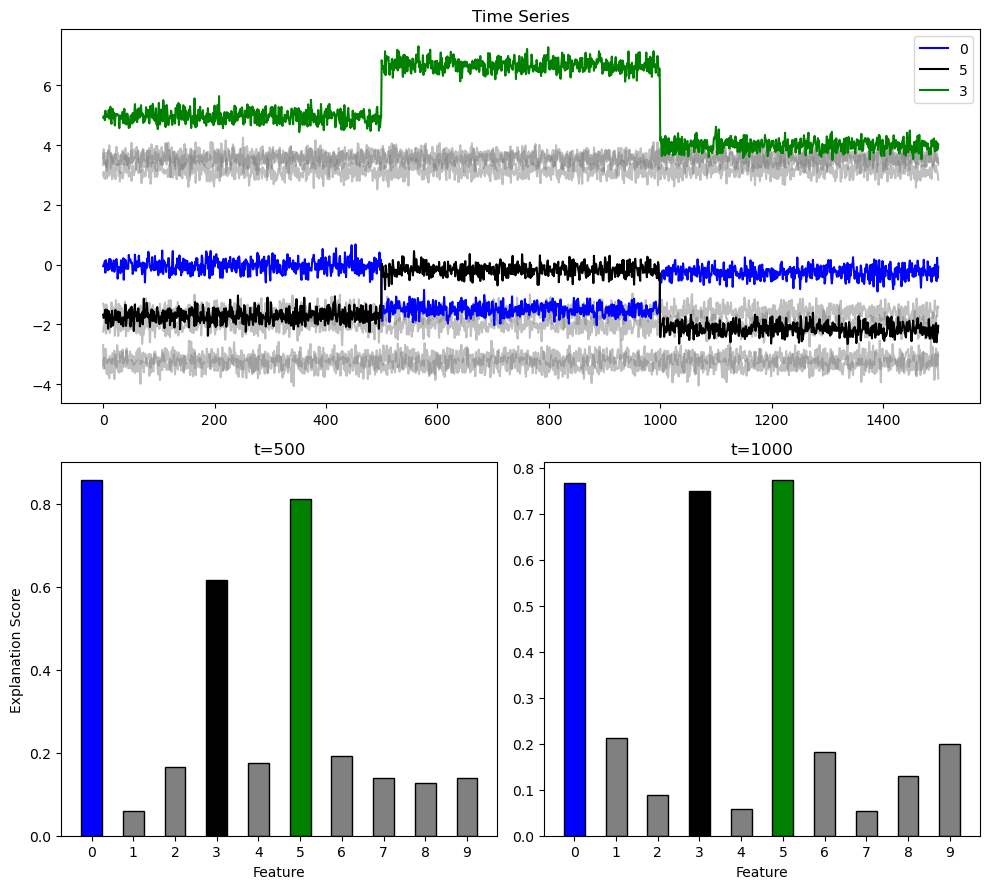

In [94]:
from matplotlib.gridspec import GridSpec


Contributions_plot = np.vstack(detector.exp_data[0][1]).mean(axis=0)
for data in zip(detector.exp_data[0][0],detector.exp_data[0][1]):
    d,c = data[0], data[1]
    Contributions_plot[d['removed_feature']] = c[d['removed_feature']]

print(Contributions_plot)

fig = plt.figure(figsize=(10,9))
gs = GridSpec(2,2)
ax1 = fig.add_subplot(gs[0, :])
ax1.set_title('Time Series')
#pd.DataFrame(X).iloc[:,varying_features].plot(ax=ax1,color=['blue','black','green'])
columns_to_select = [i for i in range(X.shape[1]) if i not in varying_features]
pd.DataFrame(X).iloc[:,columns_to_select].plot(ax=ax1,color='gray',alpha=0.5,legend=False)
pd.DataFrame(X).iloc[:,varying_features].plot(ax=ax1,color=['blue','black','green'])



Contributions_plot = np.vstack(detector.exp_data[0][1]).mean(axis=0)
for data in zip(detector.exp_data[0][0],detector.exp_data[0][1]):
    d,c = data[0], data[1]
    Contributions_plot[d['removed_feature']] = c[d['removed_feature']]

print(Contributions_plot)

# color_bars = []
# color_bars = [
#     'blue' if i in varying_features else 'gray' 
#     for i in range(Contributions_plot.shape[0])
# ]
c =0
color_bars = []
color_drifts = ['blue','black','green']
for i in range(Contributions_plot.shape[0]):
    if i in varying_features:
        color_bars.append(color_drifts[c])
        c+=1
    else:
        color_bars.append('gray')

print(color_bars)

ax2 = fig.add_subplot(gs[1, 0])

# Plot the bar chart
ax2.bar(
    x=pd.DataFrame(Contributions_plot).index,
    height=pd.DataFrame(Contributions_plot)[0],
    width = 0.5,
    color=color_bars,
    edgecolor='black'
)
ax2.set_xticks(range(X.shape[1]));
ax2.set_ylabel('Explanation Score')
ax2.set_xlabel('Feature')
ax2.set_title('t=500')

ax3 = fig.add_subplot(gs[1, 1])
ax3.set_xlabel('Feature')
ax3.set_title('t=1000')


Contributions_plot = np.vstack(detector.exp_data[1][1]).mean(axis=0)
for data in zip(detector.exp_data[1][0],detector.exp_data[1][1]):
    d,c = data[0], data[1]
    Contributions_plot[d['removed_feature']] = c[d['removed_feature']]

print(Contributions_plot)

c =0
color_bars = []
color_drifts = ['blue','black','green']
for i in range(Contributions_plot.shape[0]):
    if i in varying_features:
        color_bars.append(color_drifts[c])
        c+=1
    else:
        color_bars.append('gray')

# Plot the bar chart
ax3.bar(
    x=pd.DataFrame(Contributions_plot).index,
    height=pd.DataFrame(Contributions_plot)[0],
    width = 0.5,
    color=color_bars,
    edgecolor='black'
)
ax3.set_xticks(range(X.shape[1]));
fig.tight_layout()

In [95]:
fig.savefig('Syn_explanation_plotCPD.pdf')